## 1. Setup and Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Check for RL dependencies
try:
    import gymnasium as gym
    from gymnasium import spaces
    print("✅ Gymnasium loaded")
except ImportError:
    print("⚠️ Installing gymnasium...")
    import subprocess
    subprocess.run(['pip', 'install', 'gymnasium'], check=True)
    import gymnasium as gym
    from gymnasium import spaces

try:
    from stable_baselines3 import PPO, A2C, SAC
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.evaluation import evaluate_policy
    from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
    print("✅ Stable-Baselines3 loaded")
except ImportError:
    print("⚠️ Installing stable-baselines3...")
    import subprocess
    subprocess.run(['pip', 'install', 'stable-baselines3[extra]'], check=True)
    from stable_baselines3 import PPO, A2C, SAC
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.evaluation import evaluate_policy
    from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("\n✅ All libraries loaded successfully!")

✅ Gymnasium loaded
✅ Stable-Baselines3 loaded

✅ All libraries loaded successfully!


In [6]:
# Define paths
BASE_DIR = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_DIR = BASE_DIR / "data"
EXPORTED_DIR = DATA_DIR / "exported_data" / "per_asset"
MODEL_DIR = BASE_DIR / "models" / "xgboost_walkforward"
RESULTS_DIR = BASE_DIR / "results" / "xgboost_walkforward"

RL_OUTPUT_DIR = BASE_DIR / "models" / "rl_portfolio"
RL_RESULTS_DIR = BASE_DIR / "results" / "rl_portfolio"
RL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
RL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📂 Base directory: {BASE_DIR}")
print(f"📂 XGBoost models: {MODEL_DIR}")
print(f"📂 RL output: {RL_OUTPUT_DIR}")

📂 Base directory: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai
📂 XGBoost models: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\xgboost_walkforward
📂 RL output: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\rl_portfolio


In [7]:
# Configuration
ASSETS = [
    # US Tech Giants
    "AAPL", "NVDA", "TSLA", "MSFT", "GOOGL", "AMZN", "META",
    # US Indices ETFs  
    "SPY", "QQQ",
    # European exposure
    "EFA",
    # Bonds/Fixed Income
    "IEF", "HYG", "BIL",
    # Semiconductors
    "INTC", "AMD"
]

# RL Hyperparameters
RL_CONFIG = {
    'initial_balance': 1_000_000,
    'transaction_cost': 0.001,  # 0.1% per trade
    'max_position': 0.25,       # Max 25% in any single asset
    'min_position': 0.0,        # No shorting
    'risk_free_rate': 0.02,     # 2% annual
    'lookback_window': 20,      # 20 days of history
    'rebalance_frequency': 5,   # Rebalance every 5 days
}

print("⚙️ Configuration:")
print(f"Assets: {len(ASSETS)}")
print(f"Initial Balance: ${RL_CONFIG['initial_balance']:,}")
print(f"Transaction Cost: {RL_CONFIG['transaction_cost']*100:.2f}%")

⚙️ Configuration:
Assets: 15
Initial Balance: $1,000,000
Transaction Cost: 0.10%


## 2. Load XGBoost Predictions and Actual Returns

In [9]:
def load_oos_predictions():
    """
    Load out-of-sample predictions from walk-forward training.
    These are the XGBoost model signals for each asset.
    """
    predictions = {}
    actuals = {}
    
    for asset in ASSETS:
        oos_path = MODEL_DIR / f"{asset}_oos_predictions.csv"
        if oos_path.exists():
            df = pd.read_csv(oos_path, index_col=0, parse_dates=True)
            predictions[asset] = df['pred']
            actuals[asset] = df['true']
            print(f"✅ {asset}: {len(df)} samples ({df.index.min().date()} to {df.index.max().date()})")
        else:
            print(f"❌ {asset}: No OOS predictions found")
    
    # Combine into DataFrames
    pred_df = pd.DataFrame(predictions)
    actual_df = pd.DataFrame(actuals)
    
    # Align dates
    common_dates = pred_df.dropna().index.intersection(actual_df.dropna().index)
    pred_df = pred_df.loc[common_dates]
    actual_df = actual_df.loc[common_dates]
    
    print(f"\n📊 Combined dataset: {len(pred_df)} samples")
    print(f"📅 Date range: {pred_df.index.min().date()} to {pred_df.index.max().date()}")
    
    return pred_df, actual_df

predictions_df, returns_df = load_oos_predictions()

✅ AAPL: 2016 samples (2016-11-21 to 2024-11-25)
✅ NVDA: 2016 samples (2016-11-21 to 2024-11-25)
✅ TSLA: 2016 samples (2016-11-21 to 2024-11-25)
✅ MSFT: 2016 samples (2016-11-21 to 2024-11-25)
✅ GOOGL: 2016 samples (2016-11-21 to 2024-11-25)
✅ AMZN: 2016 samples (2016-11-21 to 2024-11-25)
✅ META: 2016 samples (2016-11-21 to 2024-11-25)
✅ SPY: 2016 samples (2016-11-21 to 2024-11-25)
✅ QQQ: 2016 samples (2016-11-21 to 2024-11-25)
✅ EFA: 2016 samples (2016-11-21 to 2024-11-25)
✅ IEF: 2016 samples (2016-11-21 to 2024-11-25)
✅ HYG: 2016 samples (2016-11-21 to 2024-11-25)
✅ BIL: 2016 samples (2016-11-21 to 2024-11-25)
✅ INTC: 2016 samples (2016-11-21 to 2024-11-25)
✅ AMD: 2016 samples (2016-11-21 to 2024-11-25)

📊 Combined dataset: 2016 samples
📅 Date range: 2016-11-21 to 2024-11-25
✅ AMD: 2016 samples (2016-11-21 to 2024-11-25)

📊 Combined dataset: 2016 samples
📅 Date range: 2016-11-21 to 2024-11-25


In [10]:
def load_price_features():
    """
    Load additional price features for state representation.
    """
    features = {}
    
    for asset in ASSETS:
        asset_dir = EXPORTED_DIR / asset
        
        # Load all splits and combine
        X_parts = []
        for split in ['train', 'val', 'test']:
            path = asset_dir / f"X_{split}.csv"
            if path.exists():
                X_parts.append(pd.read_csv(path, index_col=0, parse_dates=True))
        
        if X_parts:
            X = pd.concat(X_parts).sort_index()
            # Select key features for RL state
            key_features = [
                f'{asset}_rsi_14' if f'{asset}_rsi_14' in X.columns else None,
                f'{asset}_macd' if f'{asset}_macd' in X.columns else None,
                f'{asset}_bb_position' if f'{asset}_bb_position' in X.columns else None,
                f'{asset}_volatility_20' if f'{asset}_volatility_20' in X.columns else None,
            ]
            key_features = [f for f in key_features if f is not None]
            
            if key_features:
                features[asset] = X[key_features]
    
    if features:
        # Combine features
        all_features = pd.concat(features, axis=1)
        all_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col 
                                for col in all_features.columns]
        print(f"✅ Loaded {len(all_features.columns)} features")
        return all_features
    else:
        print("⚠️ No additional features loaded")
        return None

price_features = load_price_features()

✅ Loaded 30 features


## 3. Custom Portfolio Environment

In [11]:
class PortfolioEnv(gym.Env):
    """
    Custom Gymnasium environment for portfolio optimization.
    
    State: [XGBoost predictions, rolling features, current weights, portfolio value]
    Action: Portfolio weight allocation (continuous)
    Reward: Sharpe-like risk-adjusted return
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(self, predictions, returns, config, features=None, mode='train'):
        super().__init__()
        
        self.predictions = predictions.values
        self.returns = returns.values
        self.dates = predictions.index
        self.n_assets = len(predictions.columns)
        self.asset_names = list(predictions.columns)
        self.config = config
        self.mode = mode
        
        # Optional features
        if features is not None:
            common_idx = predictions.index.intersection(features.index)
            self.features = features.loc[common_idx].values
            self.n_features = features.shape[1]
        else:
            self.features = None
            self.n_features = 0
        
        # State dimension
        # predictions (n_assets) + rolling stats (n_assets * 3) + weights (n_assets) + portfolio info (2)
        self.lookback = config['lookback_window']
        self.state_dim = (
            self.n_assets +                    # Current predictions
            self.n_assets * 3 +                # Rolling mean, std, sharpe of predictions
            self.n_assets +                    # Current weights
            2 +                                # Portfolio value, drawdown
            self.n_features                    # Additional features
        )
        
        # Action and observation spaces
        self.action_space = spaces.Box(
            low=0.0, high=1.0, shape=(self.n_assets,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_dim,), dtype=np.float32
        )
        
        # Episode tracking
        self.current_step = 0
        self.portfolio_value = config['initial_balance']
        self.weights = np.ones(self.n_assets) / self.n_assets  # Equal weight start
        self.max_portfolio_value = self.portfolio_value
        self.returns_history = []
        self.weights_history = []
        
    def _get_observation(self):
        """Construct state observation."""
        idx = self.current_step
        
        # Current predictions (normalized)
        current_pred = self.predictions[idx]
        pred_normalized = (current_pred - current_pred.mean()) / (current_pred.std() + 1e-8)
        
        # Rolling statistics of predictions
        start_idx = max(0, idx - self.lookback)
        pred_window = self.predictions[start_idx:idx+1]
        
        if len(pred_window) > 1:
            pred_mean = pred_window.mean(axis=0)
            pred_std = pred_window.std(axis=0) + 1e-8
            pred_sharpe = pred_mean / pred_std
        else:
            pred_mean = pred_normalized
            pred_std = np.zeros(self.n_assets)
            pred_sharpe = np.zeros(self.n_assets)
        
        # Portfolio metrics
        portfolio_normalized = (self.portfolio_value / self.config['initial_balance']) - 1
        drawdown = (self.max_portfolio_value - self.portfolio_value) / self.max_portfolio_value
        
        # Build state
        state = np.concatenate([
            pred_normalized,
            pred_mean,
            pred_std,
            pred_sharpe,
            self.weights,
            [portfolio_normalized, drawdown]
        ])
        
        # Add additional features if available
        if self.features is not None and idx < len(self.features):
            feat = self.features[idx]
            feat = np.nan_to_num(feat, nan=0.0)
            state = np.concatenate([state, feat])
        elif self.n_features > 0:
            state = np.concatenate([state, np.zeros(self.n_features)])
        
        return state.astype(np.float32)
    
    def _calculate_reward(self, portfolio_return, turnover):
        """Calculate risk-adjusted reward."""
        # Transaction cost penalty
        cost = turnover * self.config['transaction_cost']
        net_return = portfolio_return - cost
        
        # Sharpe-like reward (annualized)
        if len(self.returns_history) >= 20:
            recent_returns = np.array(self.returns_history[-20:])
            mean_ret = recent_returns.mean() * 252
            std_ret = recent_returns.std() * np.sqrt(252) + 1e-8
            sharpe = (mean_ret - self.config['risk_free_rate']) / std_ret
        else:
            sharpe = net_return * 100  # Scale for early training
        
        # Drawdown penalty
        current_dd = (self.max_portfolio_value - self.portfolio_value) / self.max_portfolio_value
        dd_penalty = -current_dd * 2  # Penalize drawdowns
        
        # Diversification bonus (penalize concentration)
        hhi = np.sum(self.weights ** 2)  # Herfindahl index
        div_bonus = (1 - hhi) * 0.1
        
        reward = sharpe + dd_penalty + div_bonus
        
        return reward
    
    def step(self, action):
        """Execute one step in the environment."""
        # Normalize action to valid weights (sum to 1)
        action = np.clip(action, 0, 1)
        new_weights = action / (action.sum() + 1e-8)
        
        # Apply position limits
        new_weights = np.clip(new_weights, 
                              self.config['min_position'], 
                              self.config['max_position'])
        new_weights = new_weights / new_weights.sum()  # Renormalize
        
        # Calculate turnover
        turnover = np.sum(np.abs(new_weights - self.weights))
        
        # Get actual returns for this step
        actual_returns = self.returns[self.current_step]
        
        # Calculate portfolio return (using previous weights for realism)
        portfolio_return = np.dot(self.weights, actual_returns)
        
        # Update portfolio value
        self.portfolio_value *= (1 + portfolio_return)
        self.max_portfolio_value = max(self.max_portfolio_value, self.portfolio_value)
        
        # Update weights
        self.weights = new_weights
        
        # Track history
        self.returns_history.append(portfolio_return)
        self.weights_history.append(self.weights.copy())
        
        # Calculate reward
        reward = self._calculate_reward(portfolio_return, turnover)
        
        # Move to next step
        self.current_step += 1
        
        # Check if done
        terminated = self.current_step >= len(self.predictions) - 1
        truncated = False
        
        # Get new observation
        obs = self._get_observation()
        
        # Info dict
        info = {
            'portfolio_value': self.portfolio_value,
            'portfolio_return': portfolio_return,
            'turnover': turnover,
            'weights': self.weights.copy(),
            'date': self.dates[self.current_step] if self.current_step < len(self.dates) else None
        }
        
        return obs, reward, terminated, truncated, info
    
    def reset(self, seed=None, options=None):
        """Reset the environment."""
        super().reset(seed=seed)
        
        # Start after lookback period
        self.current_step = self.lookback
        self.portfolio_value = self.config['initial_balance']
        self.max_portfolio_value = self.portfolio_value
        self.weights = np.ones(self.n_assets) / self.n_assets
        self.returns_history = []
        self.weights_history = []
        
        obs = self._get_observation()
        return obs, {}
    
    def render(self, mode='human'):
        """Render the environment."""
        print(f"Step {self.current_step}: Portfolio = ${self.portfolio_value:,.2f}")

print("✅ PortfolioEnv class defined")

✅ PortfolioEnv class defined


## 4. Create Train/Test Environments

In [12]:
# Split data into train/test (80/20)
train_size = int(len(predictions_df) * 0.8)

train_predictions = predictions_df.iloc[:train_size]
train_returns = returns_df.iloc[:train_size]

test_predictions = predictions_df.iloc[train_size:]
test_returns = returns_df.iloc[train_size:]

print(f"📊 Training data: {len(train_predictions)} samples")
print(f"   Date range: {train_predictions.index.min().date()} to {train_predictions.index.max().date()}")
print(f"\n📊 Test data: {len(test_predictions)} samples")
print(f"   Date range: {test_predictions.index.min().date()} to {test_predictions.index.max().date()}")

📊 Training data: 1612 samples
   Date range: 2016-11-21 to 2023-04-19

📊 Test data: 404 samples
   Date range: 2023-04-20 to 2024-11-25


In [13]:
# Create environments
def make_train_env():
    return PortfolioEnv(
        predictions=train_predictions,
        returns=train_returns,
        config=RL_CONFIG,
        features=price_features.loc[train_predictions.index] if price_features is not None else None,
        mode='train'
    )

def make_test_env():
    return PortfolioEnv(
        predictions=test_predictions,
        returns=test_returns,
        config=RL_CONFIG,
        features=price_features.loc[test_predictions.index] if price_features is not None else None,
        mode='test'
    )

# Test environment
env = make_train_env()
obs, info = env.reset()
print(f"\n✅ Environment created")
print(f"   State dimension: {env.observation_space.shape}")
print(f"   Action dimension: {env.action_space.shape}")
print(f"   Number of assets: {env.n_assets}")


✅ Environment created
   State dimension: (107,)
   Action dimension: (15,)
   Number of assets: 15


## 5. Train PPO Agent

In [14]:
# Vectorized environment for training
vec_env = DummyVecEnv([make_train_env])

# PPO hyperparameters
ppo_config = {
    'learning_rate': 3e-4,
    'n_steps': 2048,
    'batch_size': 64,
    'n_epochs': 10,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'clip_range': 0.2,
    'ent_coef': 0.01,  # Encourage exploration
    'vf_coef': 0.5,
    'max_grad_norm': 0.5,
    'verbose': 1,
}

# Create PPO model
model = PPO(
    'MlpPolicy',
    vec_env,
    **ppo_config,
    tensorboard_log=str(RL_OUTPUT_DIR / "tensorboard")
)

print("✅ PPO model created")
print(f"   Policy architecture: MLP")
print(f"   Learning rate: {ppo_config['learning_rate']}")

Using cpu device
✅ PPO model created
   Policy architecture: MLP
   Learning rate: 0.0003
✅ PPO model created
   Policy architecture: MLP
   Learning rate: 0.0003


In [15]:
# Callbacks
eval_env = DummyVecEnv([make_test_env])

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=str(RL_OUTPUT_DIR / "best_model"),
    log_path=str(RL_OUTPUT_DIR / "eval_logs"),
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path=str(RL_OUTPUT_DIR / "checkpoints"),
    name_prefix="ppo_portfolio"
)

print("✅ Callbacks configured")

✅ Callbacks configured


In [16]:
# Train the model
print("🚀 Starting training...")
print("   This may take several minutes...")

TOTAL_TIMESTEPS = 100_000  # Adjust based on time available

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[eval_callback, checkpoint_callback],
    progress_bar=True
)

print("\n✅ Training complete!")

🚀 Starting training...
   This may take several minutes...
Logging to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\rl_portfolio\tensorboard\PPO_1
-----------------------------
| time/              |      |
|    fps             | 540  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------
| time/              |      |
|    fps             | 540  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 489         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011670394 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |

Eval num_timesteps=5000, episode_reward=1174.74 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.17e+03    |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.012057975 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | 0.0118      |
|    learning_rate        | 0.0003      |
|    loss                 | 6.74e+03    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0204     |
|    std                  | 1           |
|    value_loss           | 1.57e+04    |
-----------------------------------------


New best mean reward!

-----------------------------
| time/              |      |
|    fps             | 339  |
|    iterations      | 3    |
|    time_elapsed    | 18   |
|    total_timesteps | 6144 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 319         |
|    iterations           | 4           |
|    time_elapsed         | 25          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013121381 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.4       |
|    explained_variance   | 0.0244      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.58e+03    |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0219     |
|    std                  | 1.01        |
|    value_loss           | 1.34e+04    |
----------------------------------

Eval num_timesteps=10000, episode_reward=1025.83 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.03e+03    |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.013265299 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.4       |
|    explained_variance   | 0.0881      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.1e+03     |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.019      |
|    std                  | 1.01        |
|    value_loss           | 1.25e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 312   |
|    iterations      | 5     |
|    time_elapsed    | 32    |
|    total_timesteps | 10240 |
----------------

Eval num_timesteps=15000, episode_reward=1165.39 +/- 0.00

Episode length: 383.00 +/- 0.00

------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 383          |
|    mean_reward          | 1.17e+03     |
| time/                   |              |
|    total_timesteps      | 15000        |
| train/                  |              |
|    approx_kl            | 0.0135517465 |
|    clip_fraction        | 0.17         |
|    clip_range           | 0.2          |
|    entropy_loss         | -21.4        |
|    explained_variance   | 0.236        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.18e+03     |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.019       |
|    std                  | 1.01         |
|    value_loss           | 1.29e+04     |
------------------------------------------
------------------------------
| time/              |       |
|    fps             | 329   |
|    iterations      | 8     |
|    time_elapsed    | 49    |
|    total_timesteps | 16384

Eval num_timesteps=20000, episode_reward=1962.90 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.96e+03    |
| time/                   |             |
|    total_timesteps      | 20000       |
| train/                  |             |
|    approx_kl            | 0.013612178 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.247       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.75e+03    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0191     |
|    std                  | 1.01        |
|    value_loss           | 1.5e+04     |
-----------------------------------------


New best mean reward!

------------------------------
| time/              |       |
|    fps             | 328   |
|    iterations      | 10    |
|    time_elapsed    | 62    |
|    total_timesteps | 20480 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 310         |
|    iterations           | 11          |
|    time_elapsed         | 72          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.015557736 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.0003      |
|    loss                 | 5.16e+03    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0233     |
|    std                  | 1.02        |
|    value_loss           | 1.09e+04    |
---------------------------

Eval num_timesteps=25000, episode_reward=2112.69 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 2.11e+03    |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.016208863 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.5e+03     |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0214     |
|    std                  | 1.02        |
|    value_loss           | 1.11e+04    |
-----------------------------------------


New best mean reward!

------------------------------
| time/              |       |
|    fps             | 290   |
|    iterations      | 13    |
|    time_elapsed    | 91    |
|    total_timesteps | 26624 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 296         |
|    iterations           | 14          |
|    time_elapsed         | 96          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.014758745 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.335       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.73e+03    |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0221     |
|    std                  | 1.02        |
|    value_loss           | 1.51e+04    |
---------------------------

Eval num_timesteps=30000, episode_reward=2047.41 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 2.05e+03    |
| time/                   |             |
|    total_timesteps      | 30000       |
| train/                  |             |
|    approx_kl            | 0.013159428 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.5       |
|    explained_variance   | 0.509       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.85e+03    |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0197     |
|    std                  | 1.02        |
|    value_loss           | 1.12e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 269   |
|    iterations      | 15    |
|    time_elapsed    | 113   |
|    total_timesteps | 30720 |
----------------

Eval num_timesteps=35000, episode_reward=1835.47 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.84e+03    |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.016882364 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.6       |
|    explained_variance   | 0.516       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.04e+03    |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0232     |
|    std                  | 1.02        |
|    value_loss           | 1.07e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 242   |
|    iterations      | 18    |
|    time_elapsed    | 152   |
|    total_timesteps | 36864 |
----------------

Eval num_timesteps=40000, episode_reward=1501.82 +/- 0.00

Episode length: 383.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 383       |
|    mean_reward          | 1.5e+03   |
| time/                   |           |
|    total_timesteps      | 40000     |
| train/                  |           |
|    approx_kl            | 0.0187357 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -21.7     |
|    explained_variance   | 0.499     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.99e+03  |
|    n_updates            | 190       |
|    policy_gradient_loss | -0.0186   |
|    std                  | 1.03      |
|    value_loss           | 1.05e+04  |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 227   |
|    iterations      | 20    |
|    time_elapsed    | 179   |
|    total_timesteps | 40960 |
------------------------------
-----------------------

Eval num_timesteps=45000, episode_reward=1494.88 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.49e+03    |
| time/                   |             |
|    total_timesteps      | 45000       |
| train/                  |             |
|    approx_kl            | 0.013816719 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.7       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.87e+03    |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 1.03        |
|    value_loss           | 1.34e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 214   |
|    iterations      | 22    |
|    time_elapsed    | 209   |
|    total_timesteps | 45056 |
----------------

Eval num_timesteps=50000, episode_reward=1427.51 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.43e+03    |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.014158785 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.8       |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.93e+03    |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0187     |
|    std                  | 1.03        |
|    value_loss           | 1.19e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 201   |
|    iterations      | 25    |
|    time_elapsed    | 254   |
|    total_timesteps | 51200 |
----------------

Eval num_timesteps=55000, episode_reward=1725.79 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.73e+03    |
| time/                   |             |
|    total_timesteps      | 55000       |
| train/                  |             |
|    approx_kl            | 0.012438961 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.8       |
|    explained_variance   | 0.552       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.35e+03    |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0181     |
|    std                  | 1.04        |
|    value_loss           | 1.14e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 193   |
|    iterations      | 27    |
|    time_elapsed    | 285   |
|    total_timesteps | 55296 |
----------------

Eval num_timesteps=60000, episode_reward=1433.35 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.43e+03    |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.018387638 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22         |
|    explained_variance   | 0.64        |
|    learning_rate        | 0.0003      |
|    loss                 | 6.32e+03    |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0197     |
|    std                  | 1.06        |
|    value_loss           | 9.39e+03    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 186   |
|    iterations      | 30    |
|    time_elapsed    | 328   |
|    total_timesteps | 61440 |
----------------

Eval num_timesteps=65000, episode_reward=1630.38 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.63e+03    |
| time/                   |             |
|    total_timesteps      | 65000       |
| train/                  |             |
|    approx_kl            | 0.012699828 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.2       |
|    explained_variance   | 0.75        |
|    learning_rate        | 0.0003      |
|    loss                 | 5.46e+03    |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0156     |
|    std                  | 1.06        |
|    value_loss           | 1.11e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 188   |
|    iterations      | 32    |
|    time_elapsed    | 347   |
|    total_timesteps | 65536 |
----------------

Eval num_timesteps=70000, episode_reward=1613.60 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.61e+03    |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.012501394 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.3       |
|    explained_variance   | 0.671       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.63e+03    |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0186     |
|    std                  | 1.07        |
|    value_loss           | 1.03e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 199   |
|    iterations      | 35    |
|    time_elapsed    | 359   |
|    total_timesteps | 71680 |
----------------

Eval num_timesteps=75000, episode_reward=1477.62 +/- 0.00

Episode length: 383.00 +/- 0.00

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 383        |
|    mean_reward          | 1.48e+03   |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.01661923 |
|    clip_fraction        | 0.182      |
|    clip_range           | 0.2        |
|    entropy_loss         | -22.4      |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.0003     |
|    loss                 | 4.86e+03   |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0152    |
|    std                  | 1.09       |
|    value_loss           | 8.93e+03   |
----------------------------------------
------------------------------
| time/              |       |
|    fps             | 205   |
|    iterations      | 37    |
|    time_elapsed    | 369   |
|    total_timesteps | 75776 |
------------------------------
----

Eval num_timesteps=80000, episode_reward=1763.41 +/- 0.00

Episode length: 383.00 +/- 0.00

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 383       |
|    mean_reward          | 1.76e+03  |
| time/                   |           |
|    total_timesteps      | 80000     |
| train/                  |           |
|    approx_kl            | 0.0155391 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -22.5     |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.65e+03  |
|    n_updates            | 390       |
|    policy_gradient_loss | -0.0175   |
|    std                  | 1.09      |
|    value_loss           | 9.51e+03  |
---------------------------------------
------------------------------
| time/              |       |
|    fps             | 213   |
|    iterations      | 40    |
|    time_elapsed    | 383   |
|    total_timesteps | 81920 |
------------------------------
-----------------------

Eval num_timesteps=85000, episode_reward=2046.93 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 2.05e+03    |
| time/                   |             |
|    total_timesteps      | 85000       |
| train/                  |             |
|    approx_kl            | 0.016350504 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.6       |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.45e+03    |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0158     |
|    std                  | 1.09        |
|    value_loss           | 1.01e+04    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 218   |
|    iterations      | 42    |
|    time_elapsed    | 393   |
|    total_timesteps | 86016 |
----------------

Eval num_timesteps=90000, episode_reward=2081.91 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 2.08e+03    |
| time/                   |             |
|    total_timesteps      | 90000       |
| train/                  |             |
|    approx_kl            | 0.014167867 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.6       |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.09e+03    |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0219     |
|    std                  | 1.1         |
|    value_loss           | 9.76e+03    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 224   |
|    iterations      | 44    |
|    time_elapsed    | 401   |
|    total_timesteps | 90112 |
----------------

Eval num_timesteps=95000, episode_reward=1826.44 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.83e+03    |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.015048137 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.7       |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.63e+03    |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0206     |
|    std                  | 1.1         |
|    value_loss           | 8.86e+03    |
-----------------------------------------
------------------------------
| time/              |       |
|    fps             | 231   |
|    iterations      | 47    |
|    time_elapsed    | 416   |
|    total_timesteps | 96256 |
----------------

Eval num_timesteps=100000, episode_reward=1863.88 +/- 0.00

Episode length: 383.00 +/- 0.00

-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 383         |
|    mean_reward          | 1.86e+03    |
| time/                   |             |
|    total_timesteps      | 100000      |
| train/                  |             |
|    approx_kl            | 0.018281767 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -22.7       |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.13e+03    |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0206     |
|    std                  | 1.1         |
|    value_loss           | 9.14e+03    |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 236    |
|    iterations      | 49     |
|    time_elapsed    | 425    |
|    total_timesteps | 100352 |
----------


✅ Training complete!


In [17]:
# Save final model
model.save(str(RL_OUTPUT_DIR / "ppo_portfolio_final"))
print(f"✅ Model saved to {RL_OUTPUT_DIR / 'ppo_portfolio_final'}")

✅ Model saved to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\rl_portfolio\ppo_portfolio_final


## 6. Evaluate and Backtest

In [18]:
def backtest_strategy(model, env, name="RL Strategy"):
    """
    Run backtest and collect metrics.
    """
    obs, _ = env.reset()
    done = False
    
    portfolio_values = [RL_CONFIG['initial_balance']]
    returns_list = []
    weights_list = []
    dates_list = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        portfolio_values.append(info['portfolio_value'])
        returns_list.append(info['portfolio_return'])
        weights_list.append(info['weights'])
        if info['date'] is not None:
            dates_list.append(info['date'])
    
    # Calculate metrics
    returns_arr = np.array(returns_list)
    total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(returns_list)) - 1
    annual_vol = returns_arr.std() * np.sqrt(252)
    sharpe = (annual_return - RL_CONFIG['risk_free_rate']) / annual_vol if annual_vol > 0 else 0
    
    # Max drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_dd = drawdown.max()
    
    metrics = {
        'name': name,
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'final_value': portfolio_values[-1]
    }
    
    results = {
        'portfolio_values': portfolio_values,
        'returns': returns_list,
        'weights': weights_list,
        'dates': dates_list,
        'metrics': metrics
    }
    
    return results

print("✅ Backtest function defined")

✅ Backtest function defined


In [19]:
# Backtest on test data
test_env = make_test_env()
rl_results = backtest_strategy(model, test_env, "PPO RL Agent")

print("\n📊 RL Agent Performance (Test Set):")
print("=" * 50)
for key, value in rl_results['metrics'].items():
    if key != 'name':
        if 'return' in key or 'volatility' in key or 'drawdown' in key:
            print(f"  {key}: {value*100:.2f}%")
        elif 'value' in key:
            print(f"  {key}: ${value:,.2f}")
        else:
            print(f"  {key}: {value:.4f}")


📊 RL Agent Performance (Test Set):
  total_return: 912.66%
  annual_return: 358.73%
  annual_volatility: 46.70%
  sharpe_ratio: 7.6380
  max_drawdown: 47.75%
  final_value: $10,126,566.76


In [20]:
# Compare with equal-weight benchmark
def equal_weight_backtest(returns_df, config):
    """Simple equal-weight benchmark."""
    n_assets = len(returns_df.columns)
    weights = np.ones(n_assets) / n_assets
    
    portfolio_returns = returns_df.values @ weights
    portfolio_values = [config['initial_balance']]
    
    for ret in portfolio_returns:
        portfolio_values.append(portfolio_values[-1] * (1 + ret))
    
    returns_arr = np.array(portfolio_returns)
    total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(returns_arr)) - 1
    annual_vol = returns_arr.std() * np.sqrt(252)
    sharpe = (annual_return - config['risk_free_rate']) / annual_vol if annual_vol > 0 else 0
    
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_dd = drawdown.max()
    
    return {
        'portfolio_values': portfolio_values,
        'metrics': {
            'name': 'Equal Weight',
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'final_value': portfolio_values[-1]
        }
    }

benchmark_results = equal_weight_backtest(test_returns, RL_CONFIG)

print("\n📊 Equal-Weight Benchmark (Test Set):")
print("=" * 50)
for key, value in benchmark_results['metrics'].items():
    if key != 'name':
        if 'return' in key or 'volatility' in key or 'drawdown' in key:
            print(f"  {key}: {value*100:.2f}%")
        elif 'value' in key:
            print(f"  {key}: ${value:,.2f}")
        else:
            print(f"  {key}: {value:.4f}")


📊 Equal-Weight Benchmark (Test Set):
  total_return: 713.63%
  annual_return: 269.74%
  annual_volatility: 35.22%
  sharpe_ratio: 7.6020
  max_drawdown: 41.07%
  final_value: $8,136,321.23


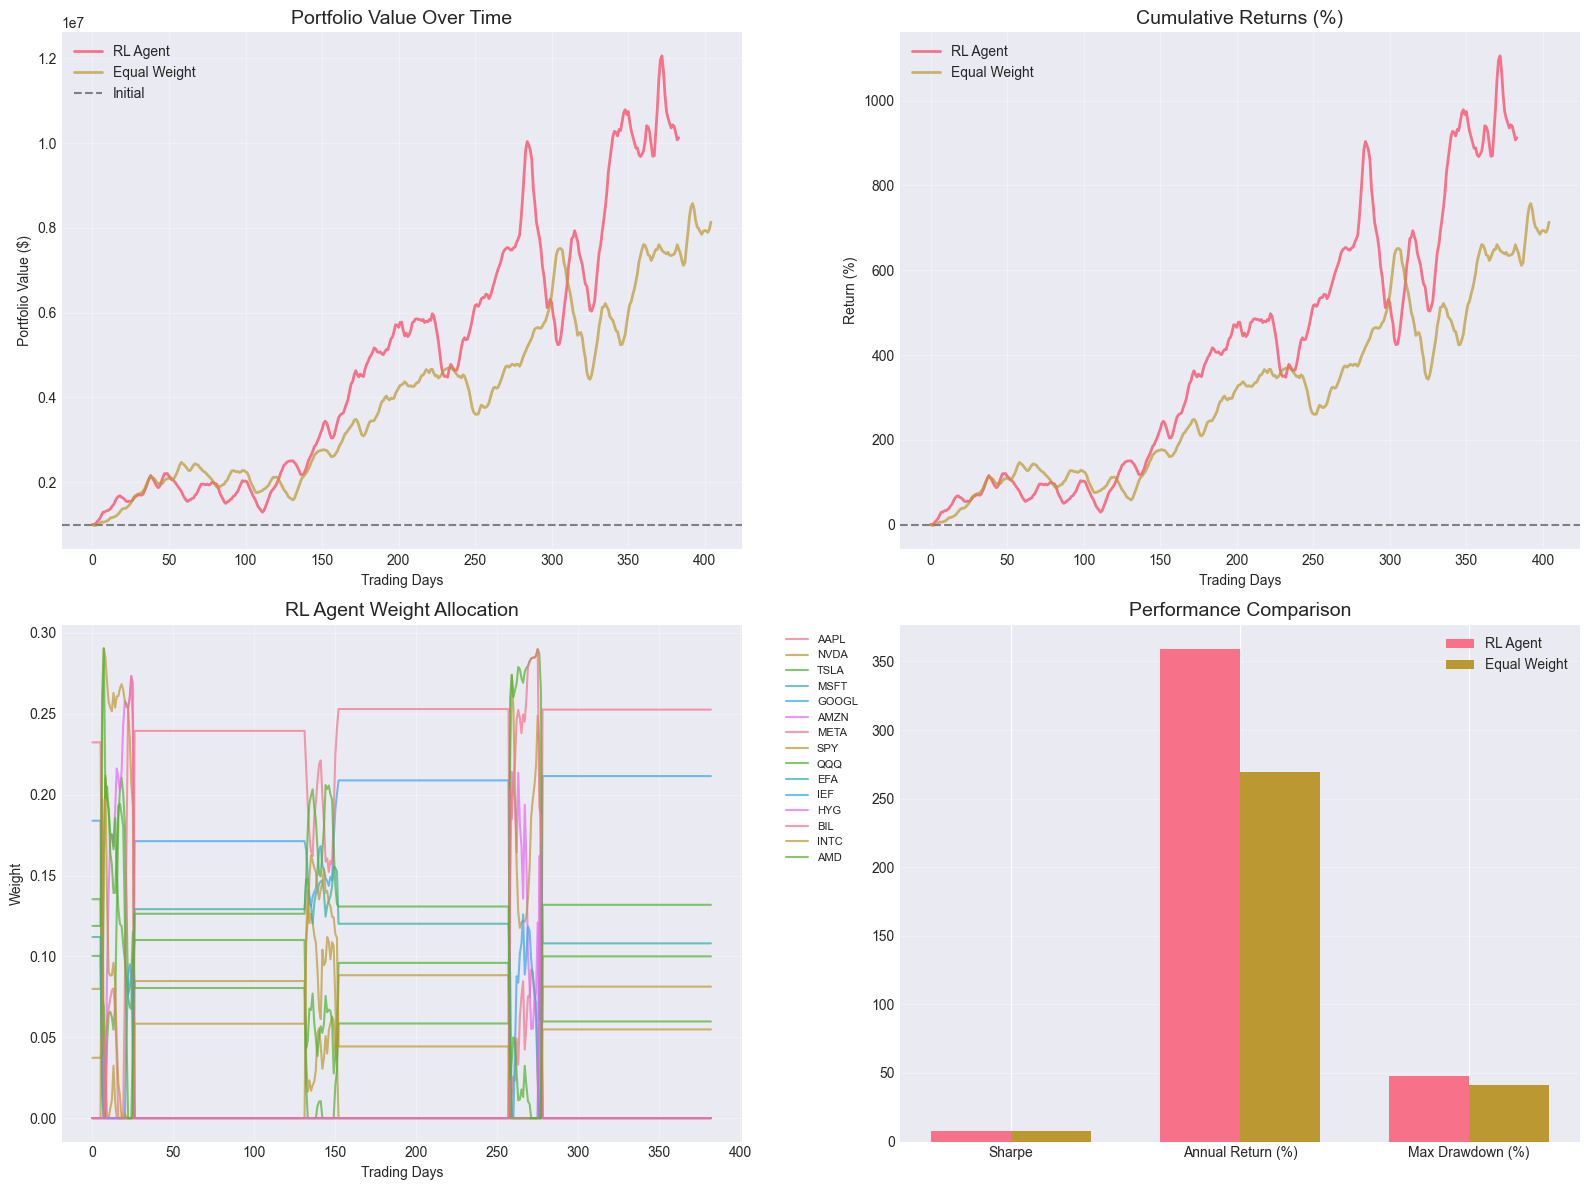


✅ Performance plot saved to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\rl_portfolio\rl_performance_comparison.png


In [21]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Portfolio Value
ax1 = axes[0, 0]
ax1.plot(rl_results['portfolio_values'], label='RL Agent', linewidth=2)
ax1.plot(benchmark_results['portfolio_values'], label='Equal Weight', linewidth=2, alpha=0.7)
ax1.axhline(y=RL_CONFIG['initial_balance'], color='gray', linestyle='--', label='Initial')
ax1.set_title('Portfolio Value Over Time', fontsize=14)
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative Returns
ax2 = axes[0, 1]
rl_cumret = np.array(rl_results['portfolio_values']) / RL_CONFIG['initial_balance'] - 1
bm_cumret = np.array(benchmark_results['portfolio_values']) / RL_CONFIG['initial_balance'] - 1
ax2.plot(rl_cumret * 100, label='RL Agent', linewidth=2)
ax2.plot(bm_cumret * 100, label='Equal Weight', linewidth=2, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='--')
ax2.set_title('Cumulative Returns (%)', fontsize=14)
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Weight Allocation Over Time
ax3 = axes[1, 0]
weights_arr = np.array(rl_results['weights'])
for i, asset in enumerate(ASSETS):
    ax3.plot(weights_arr[:, i], label=asset, alpha=0.7)
ax3.set_title('RL Agent Weight Allocation', fontsize=14)
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Weight')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# Performance Comparison Bar Chart
ax4 = axes[1, 1]
metrics_compare = ['sharpe_ratio', 'annual_return', 'max_drawdown']
x = np.arange(len(metrics_compare))
width = 0.35

rl_vals = [rl_results['metrics'][m] * (100 if 'return' in m or 'drawdown' in m else 1) for m in metrics_compare]
bm_vals = [benchmark_results['metrics'][m] * (100 if 'return' in m or 'drawdown' in m else 1) for m in metrics_compare]

ax4.bar(x - width/2, rl_vals, width, label='RL Agent')
ax4.bar(x + width/2, bm_vals, width, label='Equal Weight')
ax4.set_xticks(x)
ax4.set_xticklabels(['Sharpe', 'Annual Return (%)', 'Max Drawdown (%)'])
ax4.set_title('Performance Comparison', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RL_RESULTS_DIR / 'rl_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Performance plot saved to {RL_RESULTS_DIR / 'rl_performance_comparison.png'}")

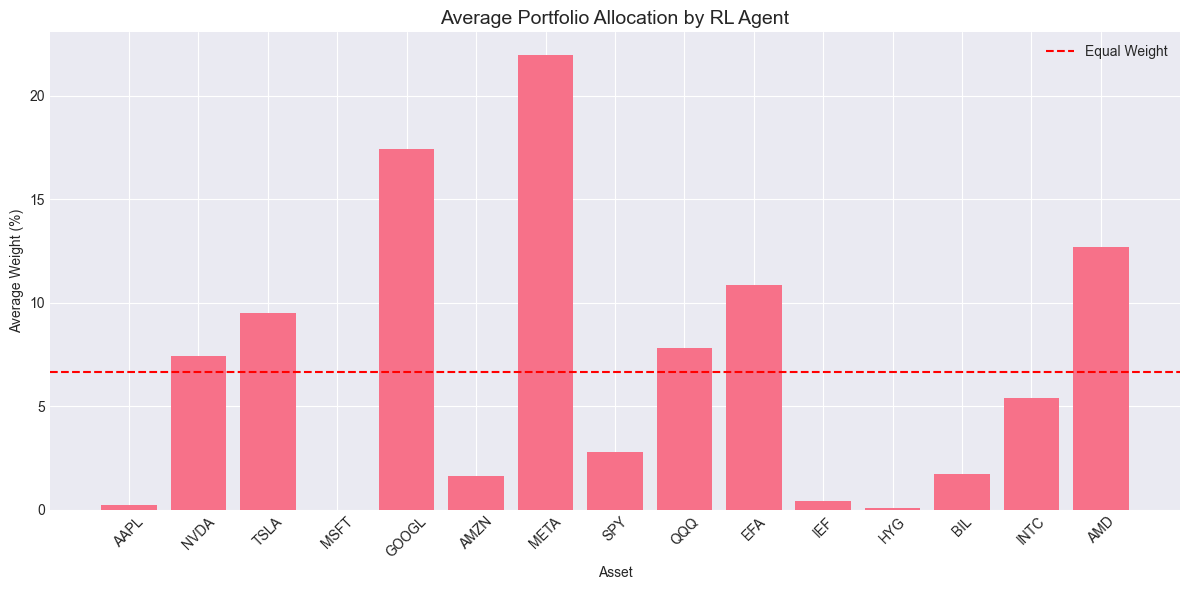


📊 Average RL Agent Allocation:
  META  :  21.96%
  GOOGL :  17.42%
  AMD   :  12.69%
  EFA   :  10.86%
  TSLA  :   9.50%
  QQQ   :   7.81%
  NVDA  :   7.43%
  INTC  :   5.40%
  SPY   :   2.78%
  BIL   :   1.75%
  AMZN  :   1.64%
  IEF   :   0.44%
  AAPL  :   0.25%
  HYG   :   0.07%
  MSFT  :   0.00%


In [22]:
# Average weight allocation
avg_weights = weights_arr.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(ASSETS, avg_weights * 100)
ax.axhline(y=100/len(ASSETS), color='red', linestyle='--', label='Equal Weight')
ax.set_title('Average Portfolio Allocation by RL Agent', fontsize=14)
ax.set_xlabel('Asset')
ax.set_ylabel('Average Weight (%)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RL_RESULTS_DIR / 'rl_avg_allocation.png', dpi=150, bbox_inches='tight')
plt.show()

# Print allocation summary
print("\n📊 Average RL Agent Allocation:")
print("=" * 40)
for asset, weight in sorted(zip(ASSETS, avg_weights), key=lambda x: -x[1]):
    print(f"  {asset:6s}: {weight*100:6.2f}%")

## 7. Save Results

In [26]:
# Save detailed results
results_summary = {
    'rl_metrics': rl_results['metrics'],
    'benchmark_metrics': benchmark_results['metrics'],
    'config': RL_CONFIG,
    'assets': ASSETS,
    'training_timesteps': TOTAL_TIMESTEPS,
    'avg_weights': dict(zip(ASSETS, avg_weights.tolist())),
    'timestamp': datetime.now().isoformat()
}

with open(RL_RESULTS_DIR / 'rl_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

# Save backtest data - align lengths
min_len = min(len(rl_results['portfolio_values']), len(benchmark_results['portfolio_values']))
backtest_df = pd.DataFrame({
    'rl_portfolio_value': rl_results['portfolio_values'][:min_len],
    'benchmark_portfolio_value': benchmark_results['portfolio_values'][:min_len]
})
backtest_df.to_csv(RL_RESULTS_DIR / 'backtest_results.csv')

print(f"✅ Results saved to {RL_RESULTS_DIR}")

✅ Results saved to c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\rl_portfolio


In [ ]:
print("\n" + "="*80)
print("🎉 RL PORTFOLIO OPTIMIZATION COMPLETE!")
print("="*80)
print(f"\n📁 Output Locations:")
print(f"   Model: {RL_OUTPUT_DIR}")
print(f"   Results: {RL_RESULTS_DIR}")
print(f"\n📊 Final Performance:")
print(f"   RL Agent Sharpe: {rl_results['metrics']['sharpe_ratio']:.4f}")
print(f"   Benchmark Sharpe: {benchmark_results['metrics']['sharpe_ratio']:.4f}")
print(f"   RL Agent Return: {rl_results['metrics']['total_return']*100:.2f}%")
print(f"   Benchmark Return: {benchmark_results['metrics']['total_return']*100:.2f}%")
print("\n✅ Ready for production deployment!")


🎉 RL PORTFOLIO OPTIMIZATION COMPLETE!

📁 Output Locations:
   Model: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\models\rl_portfolio
   Results: c:\Users\Raed\Desktop\ai-odissey\smart_investment_ai\results\rl_portfolio

📊 Final Performance:
   RL Agent Sharpe: 7.6380
   Benchmark Sharpe: 7.6020
   RL Agent Return: 912.66%
   Benchmark Return: 713.63%

✅ Ready for production deployment!


: 